In [1]:
import numpy as np
import glob
import sys
import time
import datetime
import os
import pickle

import matplotlib.pyplot as plt

In [2]:
%matplotlib nbagg

Utilities
---------

In [3]:
def printError(*arg):
    print('Error:', *arg, file=sys.stderr)
    
def printDebug(*arg):
    print('Debug:', *arg, file=sys.stderr)
    
def printWarning(*arg):
    print('Warning:', *arg, file=sys.stderr)

Simulation Model
----------------

In [4]:
class WaterHeaterModel:
    def __init__(self, m_w=1, m_h=0.2, T_env=23, P=400, r=0.085,
                 c_pw=4200, c_ph=400, h_w=25, h_a=6, rho_w=1000, rho_h=8800):
        A_hw = np.pi * r ** 2
        V_w = m_w / rho_w
        H_w = V_w / A_hw
        A_wa = H_w * 2 * r * np.pi + A_hw

        V_h = m_h / rho_h
        H_h = V_h / A_hw
        A_ha = H_h * 2 * r * np.pi + A_hw

        alpha = -(h_w * A_hw + h_a * A_ha) / (c_ph * m_h)
        beta = h_w * A_hw / (c_ph * m_h)
        gamma = h_w * A_hw / (c_pw * m_w)
        delta = -(h_w * A_hw + h_a * A_wa) / (c_pw * m_w)

        self.A = np.array([[alpha, beta], [gamma, delta]])

        alpha = P / (c_ph * m_h)
        beta = h_a * A_ha / (c_ph * m_h) * T_env
        gamma = 0
        delta = h_a * A_wa / (c_pw * m_w) * T_env

        self.B = np.array([[alpha, beta], [gamma, delta]])
        
        self.state = np.array([[T_env] * 2], dtype=np.float64).transpose()

    def __call__(self, u, dt):
        u = np.array([[u, 1]]).transpose()
        
        self.state += (np.dot(self.A, self.state) + np.dot(self.B, u)) * dt
        
        return self.state

Simulator Interface
-------------------

In [5]:
class SimulatorInterface:
    def __init__(self, m=None, time_base=datetime.datetime.now, time_factor=1.0, switching_delay=5.0, accuracy=0.125):
        if m is None:
            m = np.random.rand() + 0.7
        
        self.model = WaterHeaterModel(m)
        self.heating = False
        self.time_base = time_base
        self.last_time = time_base()
        self.time_factor = time_factor
        self.switching_delay = switching_delay
        self.accuracy = accuracy
        self.last_temperature = np.random.rand() * 80 + 20
        self.relays = []
    
    def _update(self):
        current = self.time_base()
        dt = (current - self.last_time).total_seconds() * self.time_factor
        self.advance(dt, current)
        
    def advance(self, dt, current=None):
        if current is None:
            current = self.time_base()
        self.last_time = current
        
        self.relays = [(x[0] - dt, x[1]) for x in self.relays]
        
        while len(self.relays) > 0 and self.relays[0][0] <= 0:
            self.heating = self.relays[0][1]
            self.relays = self.relays[1:]
        
        self.model(float(self.heating), dt)
    
    def read_temperature(self):
        # note: ugly delay like we have in the actual sensor readings
        result = np.round(self.last_temperature / self.accuracy + np.random.randn(1)[0] / 3) * self.accuracy
        self._update()
        self.last_temperature = self.model.state[1][0]
        return result
    
    def write_relay(self, value):
        self._update()
        self.relays.append((self.switching_delay, value))
            
    def close(self):
        pass

Hardware interface
------------------

In [6]:
class ElectronicsInterface:
    def __init__(self, gpio_pin=18, sensor=None):
        self.pin = gpio_pin
        self.sensor = None
        self.GPIO = None
        
        if sensor is None:
            temperature_sensors = glob.glob('/sys/bus/w1/devices/28-*/w1_slave')
            
            if len(temperature_sensors) > 1:
                printError('multiple temperature sensors found, please specify - entering fake mode')
                return
            elif len(temperature_sensors) == 0:
                printError('temperature sensor cannot be found - entering fake mode')
                return
            else:
                printDebug('temperature sensor found: ' + temperature_sensors[0])
                sensor = temperature_sensors[0]
        
        self.sensor = sensor
        
        try:
            self.read_temperature()
        except:
            printError('temperature sensor cannot be read - entering fake mode.')
            self.sensor = None
            return
        
        try:
            import RPi.GPIO as GPIO
            
            GPIO.setmode(GPIO.BCM)
            GPIO.setup(gpio_pin, GPIO.OUT, initial=GPIO.LOW)
            
            self.GPIO = GPIO
            
            printDebug('GPIO up and running')
        except:
            self.GPIO = None
            printError('GPIO not working - entering fake mode')
            
    def read_temperature(self):
        if self.sensor is not None:
            with open(self.sensor, 'r') as f:
                lines = f.readlines()
        else:
            lines = ['69 01 ff ff 7f ff ff ff 7e : crc=7e YES\n', '69 01 ff ff 7f ff ff ff 7e t=22562\n']
            
        if lines[0].strip()[-3:] == 'YES':
            self.temperature = int(lines[1].strip().split('=')[1]) / 1000
        else:
            self.temperature = np.nan
            printWarning('no temperature read')
            
        return self.temperature
    
    def write_relay(self, value):
        if self.GPIO is not None:
            self.GPIO.output(self.pin, value)
            
    def close(self):
        if self.GPIO is not None:
            self.GPIO.cleanup(self.pin)

In [7]:
time_factor = 100.0

In [8]:
#interface = ElectronicsInterface()
interface = SimulatorInterface(time_factor=time_factor)

In [9]:
interface.write_relay(False)

Let's try our own control mechanism
-----------------------------------

In [213]:
temperatures = []

In [214]:
target_temperature = 50

In [215]:
interface = SimulatorInterface(time_factor=time_factor)

In [216]:
interface.read_temperature()

47.625

In [217]:
#v_boost = c * m / (P * nu)
v_boost = 10

In [218]:
dT = target_temperature - interface.read_temperature()

In [219]:
boost_time = v_boost * dT

In [220]:
boost_time

271.25

In [221]:
from enum import Enum

In [222]:
class States(Enum):
    BOOST = 1
    OVERSHOOT = 2
    CONTROL = 3

In [223]:
CONTROL_EPSILON = 0.5
F_SWITCH = 1 / 15
T_CONT = 2 / F_SWITCH
F_READ = 1
T_READ = 1 / F_READ
N_CONTROL = int(T_CONT / T_READ)
NE_CONTROL = 4

NM_CONTROL = 3
NC_CONTROL = 4

CONTROL_MIN_CHANGE_TIME = 5 * 60 // N_CONTROL

TARGET_ACCURACY = 0.2
MAXIMUM_CONTROL_ERROR = 1.0
BOOST_COOL_SAMPLES = 30
MIN_BOOST_DURATION_FOR_V_UPDATE = 10
MAX_V_BOOST = 16

In [224]:
state = States.OVERSHOOT

relay_on = False
interface.write_relay(False)

current_mean = 0

control_a = 0.1
control_mu = 0.1
control_n = 0
#control_last_errors = []
control_means = []
control_changes = []

control_max = 0.1
control_min = 0.0
#control_cycles = []
control_cycle_state = 0

control_last_min = target_temperature - MAXIMUM_CONTROL_ERROR
control_last_max = target_temperature + MAXIMUM_CONTROL_ERROR

control_applied_change = False
control_last_change = 0

control_turnoff = 0

start_boost = False
start_cooling = True
start_control = False

boost_time = 0
boost_cool = 0
boost_heat = 0
boost_samples = 0
boost_start = 0


start_time = datetime.datetime.now()
handling_temps = []

now = datetime.datetime.now()

# run for three hours max
for i in range(3600 * 3):
    last_time = now
    now = datetime.datetime.now()
    temperature = interface.read_temperature()
    temperatures.append((now, temperature, relay_on, state.value, control_a, control_mu, v_boost, control_min, control_max, control_cycle_state, current_mean))
    handling_temps.append(temperature)
    print(now, temperature, relay_on, state.value, control_a, control_mu, v_boost, control_min, control_max, control_cycle_state, current_mean)
    
    dt = (now - last_time).total_seconds() * time_factor
    
    if control_turnoff > 0:
        control_turnoff -= dt
    if boost_time > 0:
        boost_time -= dt
    
    relay_target = relay_on
    
    if state == States.CONTROL:
        control_n += 1
        
        if start_control:
            control_n = 0
            #control_last_errors = []
            
            control_means = []
            control_changes = []
            
            control_cycle_state = 0
            control_last_change = 0

            start_control = False
        
        if control_n == N_CONTROL:
            control_last_change += 1
            
            control_n = 0
            
            #e = np.mean(handling_temps[-N_CONTROL:]) - target_temperature
            #control_last_errors.append(np.sign(e) if np.abs(e) - TARGET_ACCURACY > 0 else 0)
            
            #if len(control_last_errors) >= NE_CONTROL:
            #    control_last_errors = control_last_errors[-NE_CONTROL:]
            #    
            #    #if np.sum(np.abs(control_last_errors)) != 0:
            #    avg_e = np.abs(np.mean(control_last_errors))

            #    control_mu = control_mu * (.5 if avg_e < 1 / NE_CONTROL else (2 if avg_e == NE_CONTROL else 1))

            #control_a -= control_mu * control_last_errors[-1]
            #control_a = np.clip(control_a, 0, 1)

            current_mean = np.mean(handling_temps[-N_CONTROL:])
            
            control_means.append(current_mean)
            
            if current_mean > target_temperature:
                if control_cycle_state == 0:
                    control_cycle_state = 1
                    control_a = control_min
                elif control_cycle_state == 2:
                    # cycle over!
                    control_cycle_state = 1
                    control_a = control_min
                    
                    if control_max - control_min > 0.01:
                        if np.mean(control_means) > target_temperature:
                            control_max -= 0.25 * (control_max - control_min)
                            control_changes.append(-1)
                        else:
                            control_min += 0.25 * (control_max - control_min)
                            control_changes.append(1)
                            
                    control_last_min = np.min(control_means)
                    control_last_max = np.max(control_means)

                    control_applied_change = False
                            
                    control_means = []
                elif current_mean > control_last_max and (not control_applied_change or control_last_change >= CONTROL_MIN_CHANGE_TIME):
                    control_min -= 0.25* (control_max - control_min)
                    control_a = control_min
                    control_applied_change = True
                    control_last_change = 0
            elif current_mean < target_temperature:
                if control_cycle_state == 1:
                    control_cycle_state = 2
                    control_a = control_max
                    control_applied_change = False
                elif current_mean < control_last_min and (not control_applied_change or control_last_change >= CONTROL_MIN_CHANGE_TIME):
                    control_max += 0.25* (control_max - control_min)
                    control_a = control_max
                    control_applied_change = True
                    control_last_change = 0
                
            if False:
                if len(control_means) >= NM_CONTROL:
                    control_means = control_means[-NM_CONTROL:]
                    direction = np.sign(np.array(control_means[1:]) - control_means[:-1])

                    a_change = 0

                    if (direction == -1).all() and control_means[-1] < target_temperature:
                        a_change = 1
                    elif (direction == 1).all() and control_means[-1] > target_temperature:
                        a_change = -1

                    if a_change != 0:
                        control_a += control_mu * a_change

                        control_changes.append(a_change)

                        control_means = []

                if len(control_changes) >= NC_CONTROL:
                    control_changes = control_changes[-NC_CONTROL:]

                    if sum(control_changes) == 0:
                        control_mu /= 2
                        control_changes = []
                    elif np.abs(sum(control_changes)) == NC_CONTROL:
                        control_mu *= 2
                        control_changes = []
            
            if current_mean > target_temperature + MAXIMUM_CONTROL_ERROR:
                state = States.OVERSHOOT
                start_cooling = True
                
                control_max /= 2
                control_min /= 2
                
                #control_a -= control_mu
                #control_changes.append(-1)
                
            elif current_mean < target_temperature - MAXIMUM_CONTROL_ERROR:
                state = States.BOOST
                start_boost = True
                
                control_max *= 1.5
            
        if control_n == 0 and state == States.CONTROL:
            control_turnoff = control_a * T_CONT
            
            if control_turnoff > 0:
                relay_target = True
        
    elif state == States.BOOST:
        if start_boost:
            boost_start = handling_temps[-1]
            dT = target_temperature - boost_start
            boost_time = v_boost * dT
            boost_heat = boost_time
            
            relay_target = True
            start_boost = False
            boost_samples = 0
        else:
            boost_samples += 1
        
        if boost_time <= 0:
            if relay_on:
                relay_target = False
                boost_heat -= boost_time
                boost_cool = 0
            else:
                boost_cool += dt
                
                if boost_cool > BOOST_COOL_SAMPLES:
                    if np.mean(np.array(handling_temps[-BOOST_COOL_SAMPLES - 1:-1]) - np.array(handling_temps[-BOOST_COOL_SAMPLES:])) > 0:
                        
                        if boost_heat > MIN_BOOST_DURATION_FOR_V_UPDATE:
                            v_boost = np.min([boost_heat / (np.max(handling_temps[-boost_samples:]) - boost_start), MAX_V_BOOST])
                            print('New v_boost:', v_boost)
                        
                        if handling_temps[-1] > target_temperature:
                            state = States.OVERSHOOT
                            start_cooling = True
                            #v_boost /= 2
                            # TODO: v_boost is BAD now!
                        elif handling_temps[-1] > target_temperature - CONTROL_EPSILON:
                            state = States.CONTROL
                            start_control = True
                        else:
                            start_boost = True
        
        # overshooting, stop heating early!
        elif relay_on and handling_temps[-1] >= target_temperature:
            relay_target = False
            boost_heat -= boost_time
            boost_time = 0
            boost_cool = 0
        
    elif state == States.OVERSHOOT:
        relay_target = False
        
        if handling_temps[-1] < target_temperature - CONTROL_EPSILON:
            state = States.BOOST
            start_boost = True
        elif handling_temps[-1] < target_temperature:
            state = States.CONTROL
            start_control = True

    # actually switch the relay!
    if relay_on != relay_target:
        relay_on = relay_target
        interface.write_relay(relay_on)
        
    if os.path.exists('/tmp/stop'):
        break
        
    sleep_time = i + 1 - (datetime.datetime.now() - start_time).total_seconds() * time_factor
    
    if state == States.CONTROL and relay_on and sleep_time > control_turnoff:
        if control_turnoff > 0:
            time.sleep(control_turnoff / time_factor)
        control_turnoff = 0
        relay_on = False
        interface.write_relay(relay_on)
        
        sleep_time -= control_turnoff
    
    if sleep_time > 0:
        time.sleep(sleep_time / time_factor)
    
if relay_on:
    interface.write_relay(False)
    relay_on = False

23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.0
23.125
23.0
23.0
23.0
23.0
23.125
23.125
23.125
23.125
23.25
23.25
23.125
23.25
23.25
23.125
23.25
23.25
23.25
23.25
23.25
23.375
23.375
23.375
23.375
23.375
23.5
23.5
23.5
23.5
23.5
23.625
23.625
23.625
23.625
23.75
23.75
23.75
23.875
23.75
23.875
23.875
24.0
24.0
24.0
24.0
24.125
24.125
24.125
24.125
24.25
24.25
24.25
24.375
24.375
24.375
24.375
24.625
24.5
24.625
24.625
24.75
24.75
24.75
24.875
25.0
24.875
24.875
25.0
25.125
25.125
25.125
25.125
25.125
25.25
25.375
25.375
25.375
25.5
25.625
25.625
25.625
25.75
25.75
25.75
25.875
25.875
26.0
26.0
26.125
26.25
26.125
26.25
26.25
26.375
26.375
26.5
26.625
26.5
26.625
26.75
26.75
26.875
26.875
27.0
26.875
27.0
27.125
27.25
27.25
27.375
27.375
27.5
27.5
27.625
27.625
27.75
27.875
27.875
27.875
27.875
28.125
28.125
28.125
28.25
28.375
28.375
28.5
28.625
28.625
28.625
28.75
28.875
28.875
28.875
29.0
29.125
29.125
29.25
29.25
29.25
29.375
29.5
29.5
29.625
29.625

In [225]:
interface.close()

In [226]:
temperatures[-1]

(datetime.datetime(2017, 1, 15, 16, 50, 51, 501109),
 50.0,
 False,
 3,
 0.016738219465724548,
 0.1,
 14.285428571428572,
 0.016738219465724548,
 0.061004129417560914,
 1,
 50.095833333333331)

In [227]:
start_time

datetime.datetime(2017, 1, 15, 16, 49, 3, 505907)

In [228]:
N_CONTROL

30

<IPython.core.display.Javascript object>


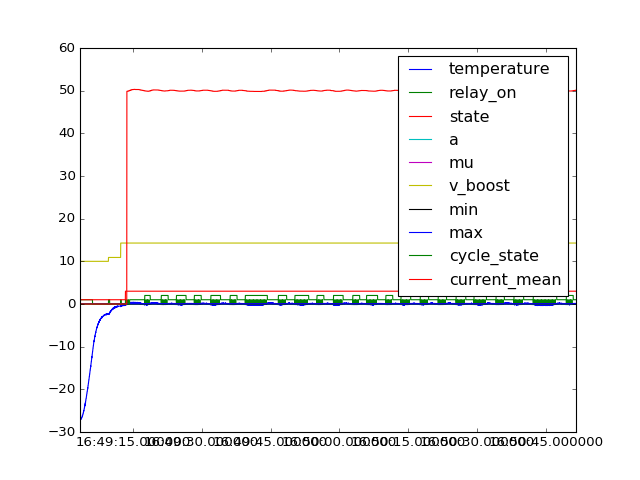

In [229]:
fig = plt.figure()
plt.plot([t[0] for t in temperatures], [t[1] - 50 for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[2] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[3] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[4] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[5] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[6] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[7] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[8] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[9] for t in temperatures])
plt.plot([t[0] for t in temperatures], [t[10] for t in temperatures])
plt.legend(['temperature', 'relay_on', 'state', 'a', 'mu', 'v_boost', 'min', 'max', 'cycle_state', 'current_mean'])